# NiCe 촉매 Kinetic 모델 비교
## 모든 촉매에 대한 시뮬레이션 결과 비교

In [2]:
# 필수 라이브러리 import
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 그래프 폰트 설정
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

In [3]:
# 반응기 조건 정의
GHSV = 120000  # mL/g/h
wcat = 0.62  # g
L = 2  # cm
ID = 0.6  # cm
A = np.pi * ID**2 / 4  # cm2
Vcat = A * L  # mL

# 초기 유량 조건
Fvi = GHSV * wcat / 3600  # mL/s
Fi = Fvi / 1000 * 1 / 0.082057 / 273.15  # mol/s
zCO2 = 0.25
zH2 = 0.75
FCO2i = Fi * zCO2
FH2i = Fi * zH2

print(f"초기 CO2 유량: {FCO2i:.6e} mol/s")
print(f"초기 H2 유량: {FH2i:.6e} mol/s")
print(f"촉매 부피: {Vcat:.4f} mL")

초기 CO2 유량: 2.305120e-04 mol/s
초기 H2 유량: 6.915361e-04 mol/s
촉매 부피: 0.5655 mL


In [4]:
# 실험 데이터 로드
df_exp = pd.read_csv('RWGS_kinetic_data_NiCe.csv')
df_exp['Fi_CO2'] = FCO2i
df_exp['Fi_H2'] = FH2i
df_exp['S_CO'] = df_exp['CO'] / (df_exp['CO'] + df_exp['CH4']) * 100
df_exp['S_CH4'] = df_exp['CH4'] / (df_exp['CO'] + df_exp['CH4']) * 100
df_exp['F_CO2'] = df_exp['Fi_CO2'] * (1 - df_exp['X'] / 100)
df_exp['F_CO'] = df_exp['Fi_CO2'] * df_exp['X'] / 100 * df_exp['S_CO'] / 100
df_exp['F_CH4'] = df_exp['Fi_CO2'] * df_exp['X'] / 100 * df_exp['S_CH4'] / 100
df_exp['F_H2O'] = df_exp['F_CO'] + df_exp['F_CH4'] * 2
df_exp['F_H2'] = df_exp['Fi_H2'] - df_exp['F_CO'] - df_exp['F_CH4'] * 4
df_exp['Fi_sum'] = df_exp['Fi_CO2'] + df_exp['Fi_H2']
df_exp['F_sum'] = df_exp['F_CO2'] + df_exp['F_CO'] + df_exp['F_CH4'] + df_exp['F_H2O'] + df_exp['F_H2']

print(f"전체 실험 데이터: {len(df_exp)} rows")
print(f"촉매 종류: {df_exp['cat'].unique()}")

전체 실험 데이터: 30 rows
촉매 종류: ['12Ni|HSA-Al2O3 (SIM)' '12Ni2Ce|HSA-Al2O3 (SIM)'
 '12Ni5Ce|HSA-Al2O3 (SIM)' '12Ni10Ce|HSA-Al2O3 (SIM)'
 '12Ni15Ce|HSA-Al2O3 (SIM)']


In [5]:
# ODE 시스템 정의 (반응 모델)
def ode(t, N, T, k):
    """
    CO2 + H2 반응 시스템 ODE
    N: [CO2, H2, CO, CH4, H2O] 몰수
    T: 온도 (°C)
    k: kinetic parameter 배열
    """
    pP = N / sum(N) * 1.01325  # 각 성분 분압 (bar)
    TK = T + 273.15  # 절대온도 (K)
    
    # 반응속도 상수 계산 (Arrhenius equation)
    kMTN = k[0] * np.exp(-k[4] / (0.008314 * TK))   # Methanation
    kRWGS = k[1] * np.exp(-k[5] / (0.008314 * TK))  # RWGS
    kDRM = k[2] * np.exp(-k[6] / (0.008314 * TK))   # Dry reforming
    kOTN = k[3] * np.exp(-k[7] / (0.008314 * TK))   # CO methanation
    
    # 흡착 평형 상수
    KCO = k[8] * np.exp(k[12] / (0.008314 * TK))
    KH2O = k[9] * np.exp(k[13] / (0.008314 * TK))
    KCO2 = k[10] * np.exp(k[14] / (0.008314 * TK))
    KH2 = k[11] * np.exp(k[15] / (0.008314 * TK))
    KDRM = k[16] * np.exp(-k[17] / TK)
    
    # Denominator (흡착항)
    den = 1 + KCO2 * pP[0] + KH2 * pP[1] + KH2O * pP[4] + KCO * pP[2]
    
    # 열역학 평형상수
    Keq_MTN = np.exp(29.72969 + 0.002703 * TK + 17791.69 / TK - 7.7973 * np.log(TK))
    Keq_RWGS = np.exp(13.64981 + 2.80537e-5 * TK - 5214.4 / TK - 1.2507 * np.log(TK))
    Keq_DRM = np.exp(-2.43006 - 0.00265 * TK - 28616.5 / TK + 5.295903 * np.log(TK))
    Keq_OTN = np.exp(16.07987 + 0.002675 * TK + 23204.1 / TK - 6.0746 * np.log(TK))
    
    # 반응 속도 계산 (mol/s)
    rMTN = 0.02 * kMTN * KH2 * KCO2 * pP[1] * (1 - pP[3] * pP[4]**2 / pP[1]**4 / pP[0] / Keq_MTN) / den**2
    rRWGS = 0.02 * kRWGS * KCO2 * pP[0] * (1 - pP[2] * pP[4] / pP[1] / pP[0] / Keq_RWGS) / den
    rDRM = kDRM * pP[3] * (1 - pP[2]**2 * pP[1]**2 / pP[3] / pP[4] / KDRM)
    rOTN = 0.02 * kOTN * KH2 * KCO * pP[1] * pP[2] * (1 - pP[3] * pP[4] / pP[1]**3 / pP[2] / Keq_OTN) / den**2
    
    # 각 성분의 시간 변화율
    dN0dt = -rMTN - rRWGS - rDRM  # CO2
    dN1dt = -4 * rMTN - rRWGS + 2 * rDRM - 3 * rOTN  # H2
    dN2dt = rRWGS + 2 * rDRM - rOTN  # CO
    dN3dt = rMTN - rDRM + rOTN  # CH4
    dN4dt = 2 * rMTN + rRWGS + rOTN  # H2O
    
    return np.array([dN0dt, dN1dt, dN2dt, dN3dt, dN4dt])

In [6]:
# ODE 시뮬레이션 함수
def solve_ode(k, T, rt):
    """
    주어진 조건에서 ODE 시뮬레이션 실행
    k: kinetic parameter
    T: 온도 (°C)
    rt: residence time (s)
    반환: [CO2, H2, CO, CH4, H2O] 최종 몰수
    """
    N0 = [FCO2i, FH2i, 1e-10, 1e-10, 1e-10]  # 초기 조건
    sol = solve_ivp(
        ode,
        t_span=(0, rt),
        y0=N0,
        args=(T, k,),
        method='BDF'
    )
    return sol.y[:, -1]  # 최종 상태 반환

In [7]:
# Kinetic parameter 파일 로드
catalyst_names = ['Ni12', 'Ni12Ce2', 'Ni12Ce5', 'Ni12Ce10', 'Ni12Ce15']
catalyst_params = {}

for cat_name in catalyst_names:
    with open(f'para_{cat_name}.json', 'r') as f:
        data = json.load(f)
        catalyst_params[cat_name] = np.array(data['para'])
        print(f"{cat_name}: {len(data['para'])} parameters loaded")

print(f"\n총 {len(catalyst_params)}개 촉매 parameter 로드 완료")

Ni12: 18 parameters loaded
Ni12Ce2: 18 parameters loaded
Ni12Ce5: 18 parameters loaded
Ni12Ce10: 18 parameters loaded
Ni12Ce15: 18 parameters loaded

총 5개 촉매 parameter 로드 완료


In [8]:
# 각 촉매별 실험 데이터 준비
catalyst_data = {}
cat_no_map = {
    1: 'Ni12',
    2: 'Ni12Ce2',
    3: 'Ni12Ce5',
    4: 'Ni12Ce10',
    5: 'Ni12Ce15'
}

for cat_no, cat_name in cat_no_map.items():
    df_cat = df_exp[df_exp['cat no'] == cat_no].copy()
    df_cat['VFi'] = df_cat['Fi_sum'] * 0.082057 * (df_cat['Temp'] + 273.15)
    df_cat['VF'] = df_cat['F_sum'] * 0.082057 * (df_cat['Temp'] + 273.15)
    df_cat['rt'] = (df_cat['VFi'] + df_cat['VF']) / 2 / Vcat
    catalyst_data[cat_name] = df_cat.reset_index(drop=True)
    print(f"{cat_name}: {len(df_cat)} data points")

Ni12: 6 data points
Ni12Ce2: 6 data points
Ni12Ce5: 6 data points
Ni12Ce10: 6 data points
Ni12Ce15: 6 data points


In [9]:
# 모든 촉매에 대해 시뮬레이션 실행
simulation_results = {}

for cat_name in catalyst_names:
    print(f"\nSimulating {cat_name}...")
    df_cat = catalyst_data[cat_name]
    k_params = catalyst_params[cat_name]
    
    results = []
    for idx, row in df_cat.iterrows():
        T = row['Temp']
        rt = row['rt']
        
        # 시뮬레이션 실행
        N_pred = solve_ode(k_params, T, rt)
        
        results.append({
            'T': T,
            'F_CO2_pred': N_pred[0],
            'F_H2_pred': N_pred[1],
            'F_CO_pred': N_pred[2],
            'F_CH4_pred': N_pred[3],
            'F_H2O_pred': N_pred[4],
            'F_CO2_exp': row['F_CO2'],
            'F_H2_exp': row['F_H2'],
            'F_CO_exp': row['F_CO'],
            'F_CH4_exp': row['F_CH4'],
            'F_H2O_exp': row['F_H2O']
        })
    
    simulation_results[cat_name] = pd.DataFrame(results)
    print(f"{cat_name} simulation complete: {len(results)} points")

print("\n전체 시뮬레이션 완료!")


Simulating Ni12...
Ni12 simulation complete: 6 points

Simulating Ni12Ce2...
Ni12Ce2 simulation complete: 6 points

Simulating Ni12Ce5...
Ni12Ce5 simulation complete: 6 points

Simulating Ni12Ce10...
Ni12Ce10 simulation complete: 6 points

Simulating Ni12Ce15...
Ni12Ce15 simulation complete: 6 points

전체 시뮬레이션 완료!


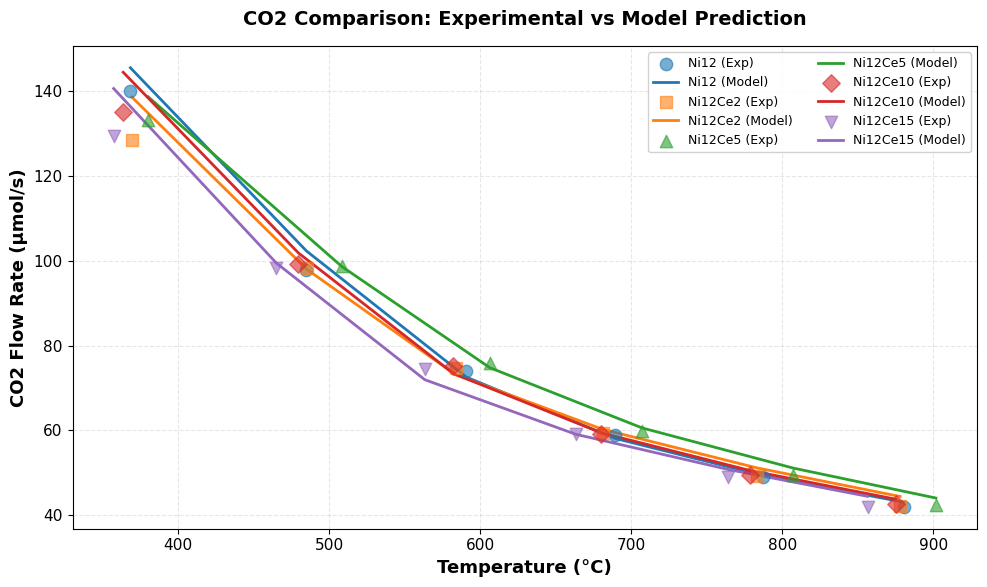

CO2 그래프 저장 완료: comparison_CO2.png


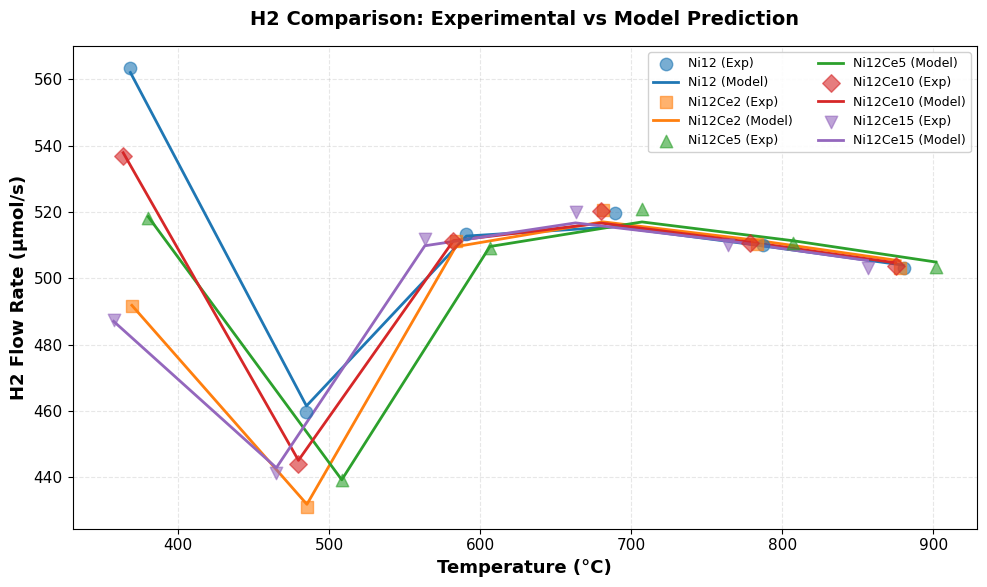

H2 그래프 저장 완료: comparison_H2.png


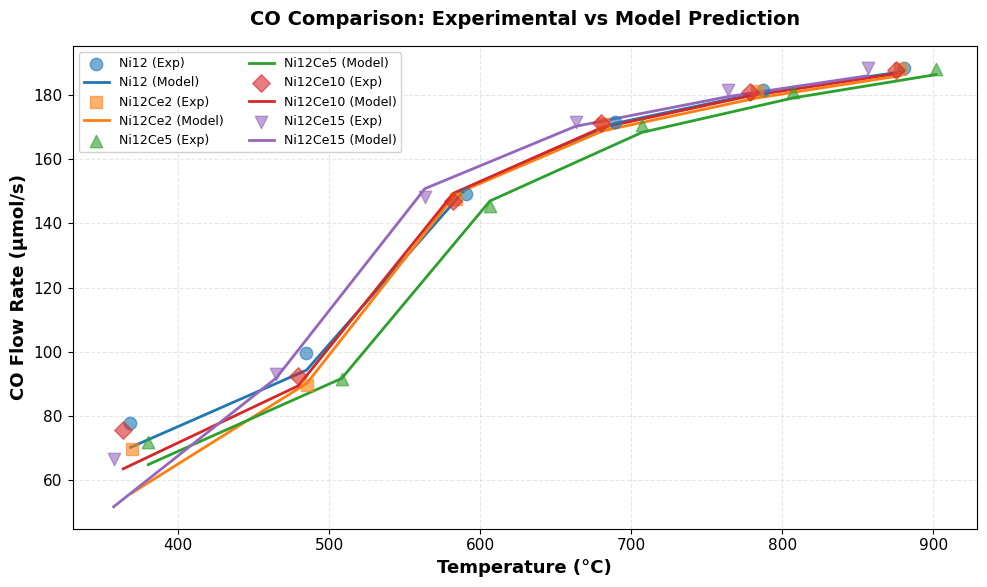

CO 그래프 저장 완료: comparison_CO.png


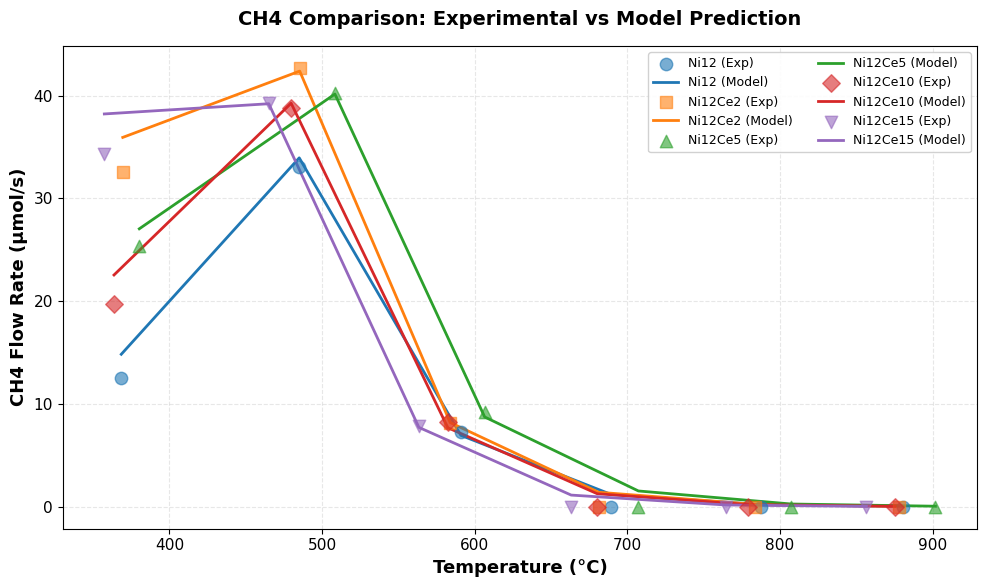

CH4 그래프 저장 완료: comparison_CH4.png


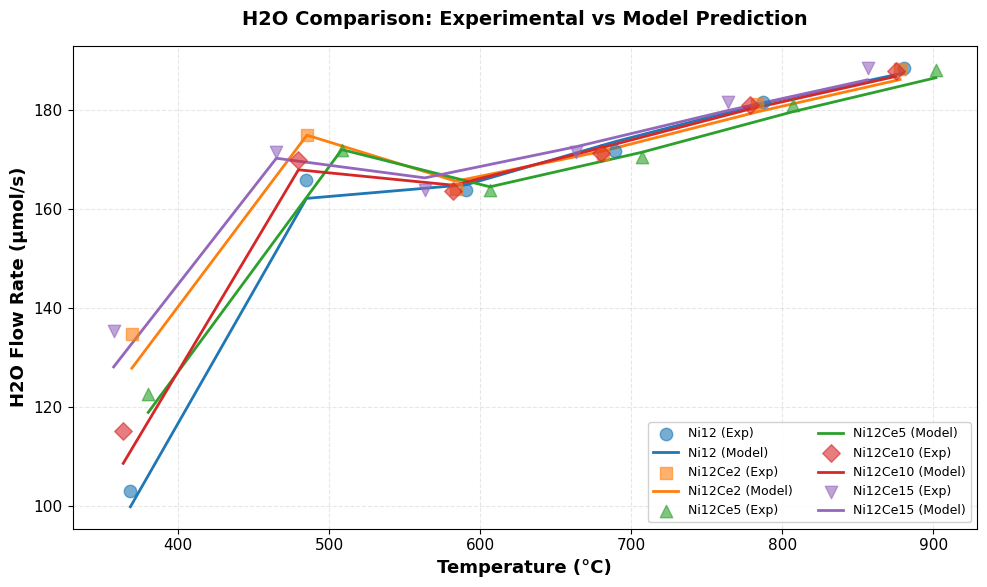

H2O 그래프 저장 완료: comparison_H2O.png


In [10]:
# 성분별 비교 그래프 생성 (각 성분마다 개별 plot)
species_list = ['CO2', 'H2', 'CO', 'CH4', 'H2O']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 촉매별 색상
markers = ['o', 's', '^', 'D', 'v']  # 촉매별 마커

for species in species_list:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for idx, cat_name in enumerate(catalyst_names):
        df_sim = simulation_results[cat_name]
        
        # 실험값 (scatter)
        ax.scatter(
            df_sim['T'], 
            df_sim[f'F_{species}_exp'] * 1e6,  # mol/s → μmol/s
            marker=markers[idx],
            s=80,
            color=colors[idx],
            alpha=0.6,
            label=f'{cat_name} (Exp)',
            zorder=3
        )
        
        # 예측값 (line)
        ax.plot(
            df_sim['T'], 
            df_sim[f'F_{species}_pred'] * 1e6,  # mol/s → μmol/s
            linestyle='-',
            linewidth=2,
            color=colors[idx],
            label=f'{cat_name} (Model)',
            zorder=2
        )
    
    # 그래프 설정
    ax.set_xlabel('Temperature (°C)', fontsize=13, fontweight='bold')
    ax.set_ylabel(f'{species} Flow Rate (μmol/s)', fontsize=13, fontweight='bold')
    ax.set_title(f'{species} Comparison: Experimental vs Model Prediction', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=9, ncol=2, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.savefig(f'comparison_{species}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"{species} 그래프 저장 완료: comparison_{species}.png")

In [11]:
# 각 촉매별 예측 정확도 계산
print("\n=== 촉매별 예측 정확도 (RMSE) ===")
print(f"{'Catalyst':<12} | {'CO2':<8} | {'H2':<8} | {'CO':<8} | {'CH4':<8} | {'H2O':<8}")
print("-" * 70)

for cat_name in catalyst_names:
    df_sim = simulation_results[cat_name]
    rmse_values = []
    
    for species in species_list:
        exp = df_sim[f'F_{species}_exp'].values
        pred = df_sim[f'F_{species}_pred'].values
        rmse = np.sqrt(np.mean((pred - exp)**2)) * 1e6  # μmol/s
        rmse_values.append(f"{rmse:.4f}")
    
    print(f"{cat_name:<12} | {' | '.join(rmse_values)}")

print("\n(단위: μmol/s)")


=== 촉매별 예측 정확도 (RMSE) ===
Catalyst     | CO2      | H2       | CO       | CH4      | H2O     
----------------------------------------------------------------------
Ni12         | 3.0025 | 2.0474 | 3.9552 | 1.1204 | 2.2128
Ni12Ce2      | 4.3988 | 1.8553 | 5.7962 | 1.4954 | 3.0944
Ni12Ce5      | 2.4538 | 1.7687 | 3.2604 | 0.9547 | 1.7983
Ni12Ce10     | 4.0829 | 1.6564 | 5.2880 | 1.2895 | 2.9500
Ni12Ce15     | 4.8487 | 2.0693 | 6.3820 | 1.6441 | 3.4197

(단위: μmol/s)


In [12]:
# 이미 촉매별로 RMSE를 계산했으므로, 이제 모든 촉매-종 전체 데이터에 대한 MAPE(Mean Absolute Percentage Error)를 직접 계산

total_exp = []
total_pred = []

for species in species_list:
    for cat_name in catalyst_names:
        df_sim = simulation_results[cat_name]
        total_exp.extend(df_sim[f'F_{species}_exp'].values)
        total_pred.extend(df_sim[f'F_{species}_pred'].values)

total_exp = np.array(total_exp)
total_pred = np.array(total_pred)

# 분모가 0인 경우 0으로 처리
mape_total = np.mean(np.where(total_exp != 0, np.abs((total_exp - total_pred) / total_exp), 0)) * 100

print("\n=== 전체 데이터(Catalyst, Species 전체)에 대한 총합 MAPE (%) ===")
print(f"Total MAPE: {mape_total:.2f} %")
print("(MAPE의 단위: %)")



=== 전체 데이터(Catalyst, Species 전체)에 대한 총합 MAPE (%) ===
Total MAPE: 2.21 %
(MAPE의 단위: %)


/tmp/ipykernel_6550/2042169995.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_total = np.mean(np.where(total_exp != 0, np.abs((total_exp - total_pred) / total_exp), 0)) * 100


In [13]:
# 전체 데이터(Catalyst, Species 전체)에 대한 R^2 계산

# 분모가 0이거나 표준편차가 0인 경우를 피해서 계산
mean_exp = np.mean(total_exp)
ss_res = np.sum((total_exp - total_pred) ** 2)
ss_tot = np.sum((total_exp - mean_exp) ** 2)
if ss_tot == 0:
    r2_total = np.nan
else:
    r2_total = 1 - (ss_res / ss_tot)

print("\n=== 전체 데이터(Catalyst, Species 전체)에 대한 총합 R^2 ===")
if np.isnan(r2_total):
    print("Total R^2: 계산 불가 (분산이 0)")
else:
    print(f"Total R^2: {r2_total:.4f}")
print("(R^2의 범위: -∞ ~ 1, 1에 가까울수록 예측이 정확함)")




=== 전체 데이터(Catalyst, Species 전체)에 대한 총합 R^2 ===
Total R^2: 0.9996
(R^2의 범위: -∞ ~ 1, 1에 가까울수록 예측이 정확함)


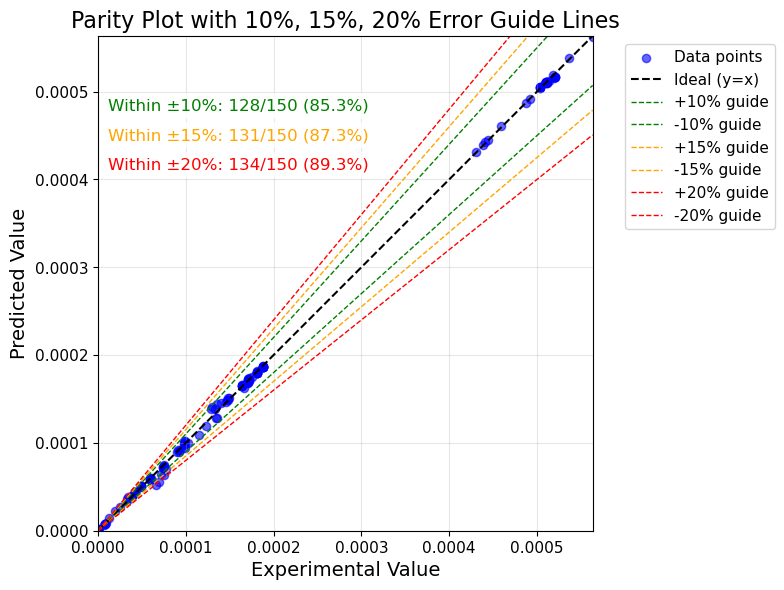

In [15]:
import matplotlib.pyplot as plt

# Parity plot 준비
plt.figure(figsize=(8, 8))
plt.scatter(total_exp, total_pred, c='blue', s=35, alpha=0.6, label='Data points')
min_val = min(np.min(total_exp), np.min(total_pred))
max_val = max(np.max(total_exp), np.max(total_pred))
x = np.linspace(min_val, max_val, 100)

# y=x (이상적 예측) 선 추가
plt.plot(x, x, 'k--', label='Ideal (y=x)')

# 오차 가이드라인 추가 (10%, 15%, 20%)
for p, c in zip([0.10, 0.15, 0.20], ['green', 'orange', 'red']):
    plt.plot(x, x*(1+p), linestyle='--', color=c, linewidth=1, label=f'+{int(p*100)}% guide')
    plt.plot(x, x*(1-p), linestyle='--', color=c, linewidth=1, label=f'-{int(p*100)}% guide')

# 각 오차 범위에 몇 개의 데이터가 포함되는지 계산
# (상대 오차로, 실제값 기준)
def in_percent_range(true, pred, pct):
    true, pred = np.array(true), np.array(pred)
    mask = np.zeros_like(true, dtype=bool)
    nonzero_idx = true != 0
    ratio = np.zeros_like(true, dtype=float)
    ratio[nonzero_idx] = np.abs((pred[nonzero_idx] - true[nonzero_idx]) / true[nonzero_idx])
    mask[nonzero_idx] = ratio[nonzero_idx] <= pct
    return np.sum(mask)

n_total = len(total_exp)
counts = []
ranges = [0.10, 0.15, 0.20]
for pct in ranges:
    cnt = in_percent_range(total_exp, total_pred, pct)
    counts.append(cnt)

# Annotate counts on the plot
ypos = max_val - (max_val-min_val)*0.15 # 대략적으로 상단에 쓰기
for i, pct in enumerate(ranges):
    plt.text(min_val + (max_val-min_val)*0.02, ypos - i*(max_val-min_val)*0.06, 
             f"Within ±{int(pct*100)}%: {counts[i]}/{n_total} ({counts[i]/n_total*100:.1f}%)",
             fontsize=12, color=['green','orange','red'][i], bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.xlabel('Experimental Value', fontsize=14)
plt.ylabel('Predicted Value', fontsize=14)
plt.title('Parity Plot with 10%, 15%, 20% Error Guide Lines', fontsize=16)
plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.gca().set_aspect('equal', 'box')
plt.grid(alpha=0.3, zorder=0)
plt.tight_layout()
plt.show()
